In [48]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo
from exobuilder.data.exostorage import EXOStorage
from IPython.core.display import display, HTML

from sklearn import linear_model, cross_validation, naive_bayes, ensemble, tree, neighbors, cluster, preprocessing

import pandas as pd
import numpy as np
import scipy
import pprint

import glob
from pandas.tseries.offsets import *

In [49]:
%pylab inline
%load_ext autoreload
%autoreload 2

figsize(20,10)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Rng strategies

In [50]:
#
# random time series
#
df = pd.DataFrame()
for i in range(1000):
    
    date = pd.date_range(start='2015-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

# Set EXO name here

In [74]:
# Loading global setting for MongoDB etc.
from scripts.settings import *

try:
    from scripts.settings_local import *
except:
    pass

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)
pp = pprint.PrettyPrinter(indent=4)

exo_list = storage.exo_list()
pp.pprint(exo_list)


#exo_series, exo_dict = storage.load_series('ES_BearishCollarBW')
exo_series, exo_dict = storage.load_series('CL_PutSpread')
exo_series = exo_series[exo_series.columns[0]]

[   'ES_BullishCollarBW',
    'ES_BearishCollarBW',
    'ES_CallSpread',
    'ES_PutSpread',
    'CL_BullishCollarBW',
    'CL_BearishCollarBW',
    'CL_CallSpread',
    'CL_PutSpread',
    'NG_BullishCollarBW',
    'NG_BearishCollarBW',
    'NG_CallSpread',
    'NG_PutSpread',
    'ES_ContFut',
    'NG_ContFut',
    'CL_ContFut',
    'ZC_BullishCollarBW',
    'ZC_BearishCollarBW',
    'ZC_CallSpread',
    'ZC_PutSpread',
    'ZC_ContFut',
    'ZN_BullishCollarBW',
    'ZN_BearishCollarBW',
    'ZN_CallSpread',
    'ZN_PutSpread',
    'ZN_ContFut']


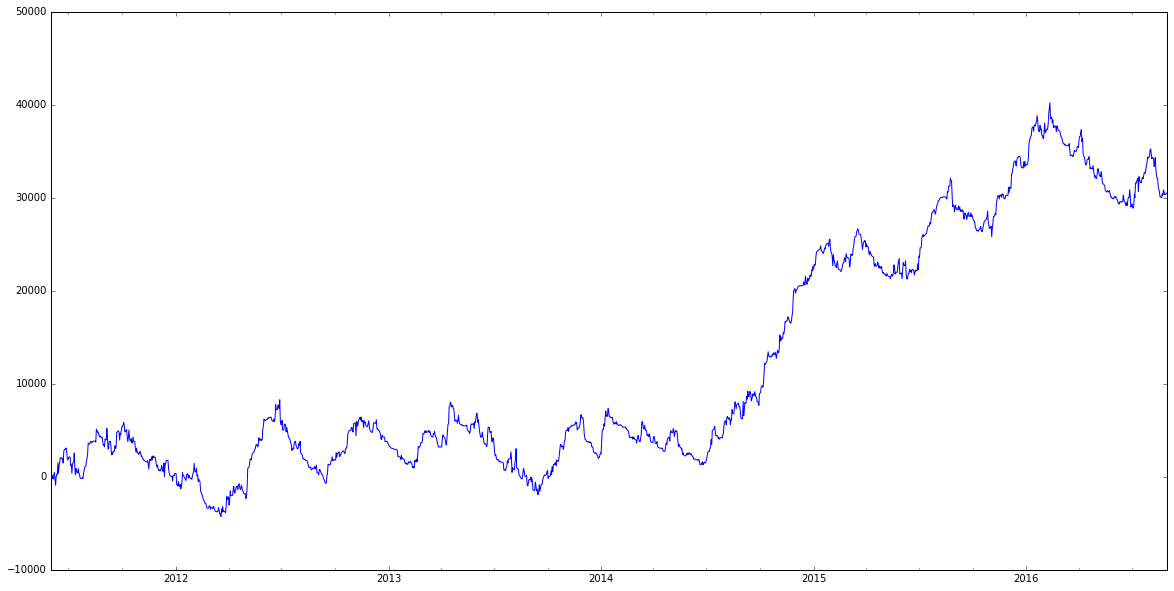

In [75]:
exo_series.plot()

# Saved Swarm universes as input

In [247]:
df = pd.DataFrame()
exoname = 'CL'
direction = 'Long' # Long short
exostrategy = 'PutSpread' # CallSpread .. etc

for file in glob.glob("../swarms/*.swm"):
    swarmname = file.split('/')[-1]
    
    if (exoname in swarmname) and (direction in swarmname) and (exostrategy in swarmname):
        if df.size == 0:
            df = Swarm.load('../swarms/'+swarmname).raw_swarm
        else:
            df = pd.concat([df, Swarm.load('../swarms/'+swarmname).raw_swarm], axis=1)
    #print(file.split('/')[-1])
    #break
    
df = df.dropna(how='all')

## Single swarm

In [44]:
# set file name here
swarm_file = 'CL_CallSpread_Long_BollingerBands'

# Real swarm from .swm
df = Swarm.load('../swarms/'+swarm_file+'.swm').raw_swarm
#df = df

# Alphas

In [116]:
instruments_filter = ['CL']  # Select ALL
#instruments_filter = ['ES']

exo_filter = ['*'] # Select ALL
#exo_filter = ['CallSpread']

#direction_filter = [0, -1, 1] # Select ALL
direction_filter = [1]

alpha_filter = ['*']  # Select ALL
#alpha_filter = ['MaCross', 'PointAndFigurePatterns']

swmdf, swm_data = storage.swarms_list(instruments_filter, direction_filter, alpha_filter, exo_filter)

df = swmdf

In [117]:
#swarm = Swarm.load('../swarms/'+swarm_file+'.swm')

# Fixing a duplicated colums

In [183]:
df = df[df.columns.drop_duplicates()]

## Systems overall performance estimation

In [248]:
temp_l = []

dynamic_exo_selection_flag = True

for strat in df.columns:
        input_strategy_data = df[strat] # This data is used in metrics calc
        
        if dynamic_exo_selection_flag == True:
            # Dynamic EXO selection
            try:
                exo_series, exo_dict = storage.load_series(strat.split('_')[0]+'_'+strat.split('_')[1])
                exo_series = exo_series[exo_series.columns[0]]

            except IndexError:
                print('Seems like a swarm universes or single swarm are used as input. Dynamic EXO selection is disabled.')
                dynamic_exo_selection_flag = False
        
        
        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan
        
        strategy_pctchange = input_strategy_data.pct_change(1).replace([np.inf, -np.inf], np.nan)
        exo_series_pctchange = exo_series.pct_change(1).replace([np.inf, -np.inf], np.nan)


        strategy_pos_pctchange = strategy_pctchange[strategy_pctchange > 0]
        exo_series_pos_pctchange = exo_series_pctchange[exo_series_pctchange > 0]

        strategy_neg_pctchange = strategy_pctchange[strategy_pctchange < 0]
        exo_series_neg_pctchange = exo_series_pctchange[exo_series_pctchange < 0]
        
        try:
            d = {'strategy': strat,
                'stats_pricechange_modsharpe': modsharpe.values[0],
                'stats_up_beta': strategy_pos_pctchange.ix[:,0].cov(exo_series_pos_pctchange) / exo_series_pos_pctchange.var(),
                'stats_down_beta': strategy_neg_pctchange.ix[:,0].cov(exo_series_neg_pctchange) / exo_series_neg_pctchange.var(),
                'stats_netprofit': netprofit.values[0],
                'stats_max_dd': max_dd.values[0], 
                'stats_recovery_factor': (netprofit / np.abs(max_dd)).values[0],
                'stats_profit_factor': (profit_factor).values[0]
                 }

            temp_l.append(d)
        
        except:
            d = {'strategy': strat,
                'stats_pricechange_modsharpe': modsharpe,
                'stats_up_beta': strategy_pos_pctchange.cov(exo_series_pos_pctchange) / exo_series_pos_pctchange.var(),
                'stats_down_beta': strategy_neg_pctchange.cov(exo_series_neg_pctchange) / exo_series_neg_pctchange.var(),
                'stats_netprofit': netprofit,
                'stats_max_dd': max_dd, 
                'stats_recovery_factor': (netprofit / np.abs(max_dd)),
                'stats_profit_factor': (profit_factor)
                 }

            temp_l.append(d)
            
        #print(strat.split('_')[0]+'_'+strat.split('_')[1])

Seems like a swarm universes or single swarm are used as input. Dynamic EXO selection is disabled.


/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [249]:
strategies_performance_df = pd.DataFrame(temp_l).dropna()

strategies_performance_df['stats_betas_ratio'] = strategies_performance_df.stats_up_beta / strategies_performance_df.stats_down_beta
strategies_performance_df['stats_betas_difference'] = strategies_performance_df.stats_up_beta - strategies_performance_df.stats_down_beta

strategies_performance_df.set_index('strategy', inplace=True)

strategies_performance_df = pd.DataFrame(preprocessing.normalize(strategies_performance_df), index=strategies_performance_df.index,
                                         columns=strategies_performance_df.columns)

print(strategies_performance_df.shape)
strategies_performance_df.head()

(3797, 9)


,stats_down_beta,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_up_beta,stats_betas_ratio,stats_betas_difference
strategy,,,,,,,,,
"(1, 10, 2, 0.29999999999999999, 20)",8.311674e-08,-0.258937,0.965894,0.000002,0.000041,0.000126,8.006778e-08,0.000032,-3.048966e-09
"(1, 10, 2, 0.31, 20)",1.006641e-07,-0.252107,0.967699,0.000002,0.000040,0.000125,7.235763e-08,0.000023,-2.830647e-08
"(1, 20, 2, 0.29999999999999999, 20)",2.997622e-07,-0.295699,0.955281,0.000002,0.000043,0.000116,1.020694e-07,0.000012,-1.976928e-07
"(1, 20, 2, 0.31, 20)",2.955729e-07,-0.277841,0.960627,0.000002,0.000042,0.000121,7.849548e-08,0.000009,-2.170775e-07
"(1, 30, 2, 0.29999999999999999, 20)",1.871841e-07,-0.300993,0.953626,0.000002,0.000041,0.000107,1.435156e-07,0.000026,-4.366854e-08


# Clustering by all performance stats series

In [272]:
clustering_model = cluster.KMeans(n_clusters=5, precompute_distances=True, n_init=100, max_iter=3000)
clustering_model.fit(strategies_performance_df.as_matrix())

KMeans(copy_x=True, init='k-means++', max_iter=3000, n_clusters=5, n_init=100,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

In [273]:
strategies_performance_df['cluster'] = clustering_model.labels_

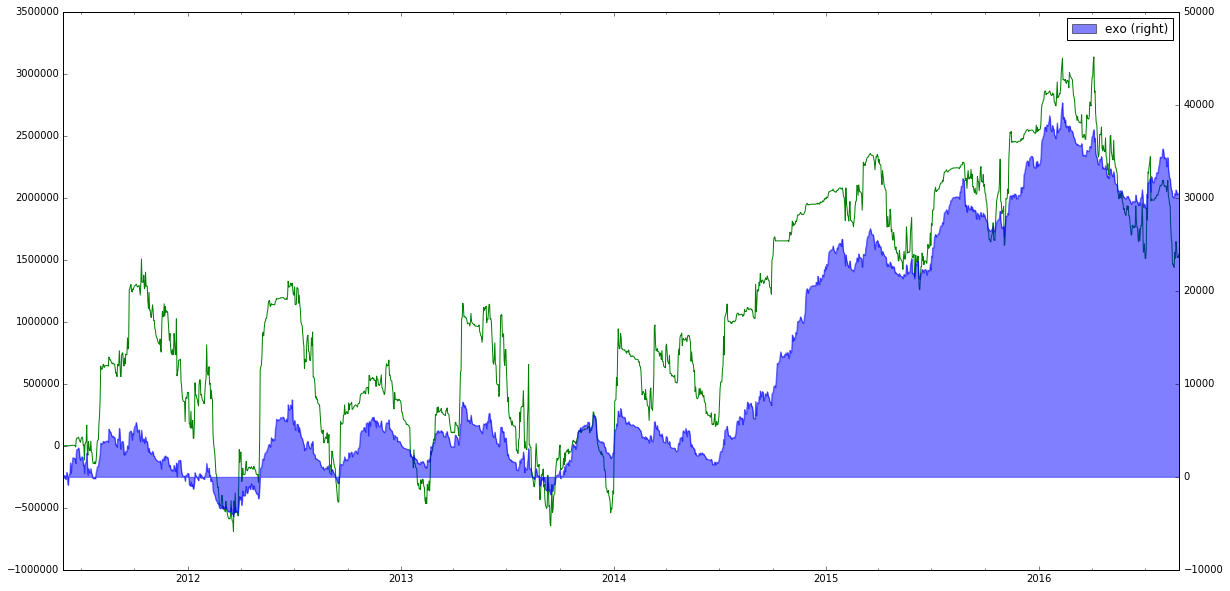

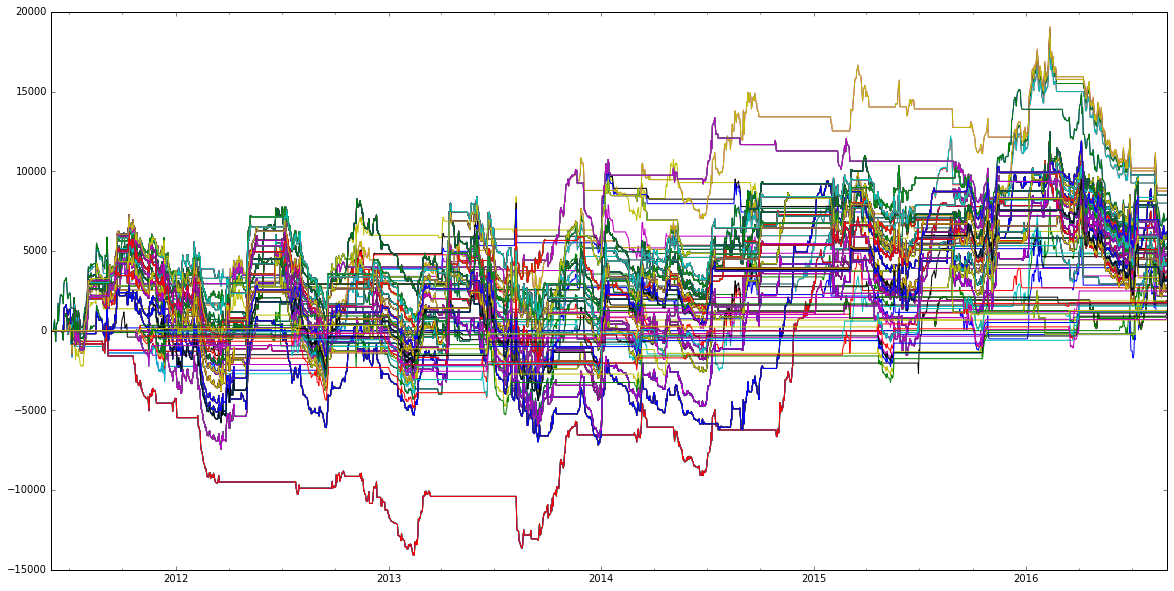

In [289]:
figsize(20,10)

# Change this variable to select a strategies in the cluster
cluster_n = 4

exo_series.plot(kind='area',legend='EXO', stacked=False, secondary_y=True)
df[strategies_performance_df[strategies_performance_df.cluster == cluster_n].index].sum(1).plot(legend=False)
df[strategies_performance_df[strategies_performance_df.cluster == cluster_n].index].plot(legend=False)

# Cluster and performance metrics dependencies

## X - Cluster
## Y - Performance metrics(1 - mod.sharpe, 2 - profit factor, 3 - recovery factor, 4 - betas ratio, 5 - betas difference, 6 - up beta, 7 - down beta)

In [275]:
figsize(5,2)

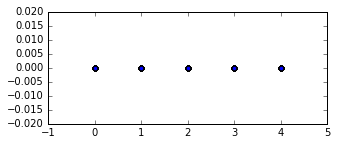

In [276]:
scatter(strategies_performance_df.cluster, strategies_performance_df.stats_pricechange_modsharpe)

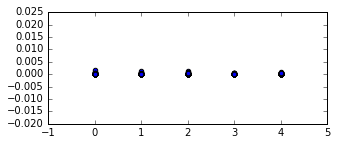

In [277]:
scatter(strategies_performance_df.cluster, strategies_performance_df.stats_profit_factor)

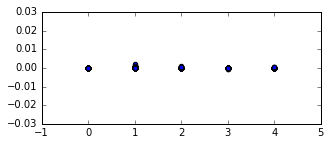

In [278]:
scatter(strategies_performance_df.cluster, strategies_performance_df.stats_recovery_factor)

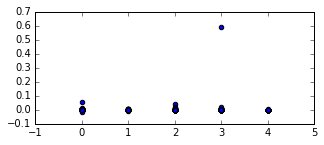

In [279]:
scatter(strategies_performance_df.cluster, strategies_performance_df.stats_betas_ratio)

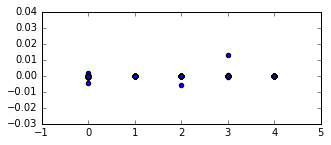

In [280]:
scatter(strategies_performance_df.cluster, strategies_performance_df.stats_betas_difference)

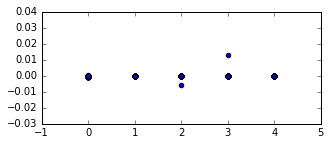

In [281]:
scatter(strategies_performance_df.cluster, strategies_performance_df.stats_up_beta)

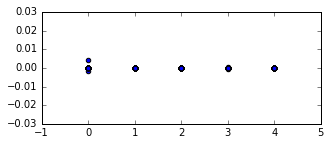

In [282]:
scatter(strategies_performance_df.cluster, strategies_performance_df.stats_down_beta)

In [283]:
figsize(20,10)

# Clusters overall performance estimation
# This is needed for defining the best cluster

In [284]:
temp_l = []

for cluster_number in strategies_performance_df.cluster.unique():
        input_strategy_data = df[strategies_performance_df[strategies_performance_df.cluster == cluster_number].index].sum(1) # This data is used in metrics calc
               
        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = input_strategy_data.ix[-1] - input_strategy_data.ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan
        

        d = {'cluster': cluster_number,
            'stats_pricechange_modsharpe': modsharpe,
            #'stats_up_beta': strategy_pos_pctchange.cov(exo_series_pos_pctchange) / exo_series_pos_pctchange.var(),
            #'stats_down_beta': strategy_neg_pctchange.cov(exo_series_neg_pctchange) / exo_series_neg_pctchange.var(),
            'stats_netprofit': netprofit,
            'stats_max_dd': max_dd, 
            'stats_recovery_factor': (netprofit / np.abs(max_dd)),
            'stats_profit_factor': (profit_factor)
             }
             #'stats_winrate': winrate }

        temp_l.append(d)
            
        #print(strat.split('_')[0]+'_'+strat.split('_')[1])

In [285]:
clusters_performance_df = pd.DataFrame(temp_l).dropna()
clusters_performance_df.set_index('cluster', inplace=True)

In [286]:
clusters_performance_rank = clusters_performance_df.rank().sum(1).sort_values(ascending=False).astype(int)
clusters_performance_rank

cluster
1    21
2    18
4    17
0    12
3     7
dtype: int64

In [221]:
df = df[strategies_performance_df[strategies_performance_df.cluster.isin(clusters_performance_rank.index[:1])].index]

# .
# Do a same thing as regular ranking procedure
# .

In [222]:
temp_l = []

for strat in df.columns:

        input_strategy_data = df[strat] # This data is used in metrics calc

        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan

        try:
            d = {'strategy': strat,
                'stats_pricechange_modsharpe': modsharpe.values[0],
                'stats_netprofit': netprofit.values[0],
                'stats_max_dd': max_dd.values[0], 
                'stats_recovery_factor': (netprofit / np.abs(max_dd)).values[0],
                'stats_profit_factor': (profit_factor).values[0]
                 }

            temp_l.append(d)
        
        except:
            d = {'strategy': strat,
                'stats_pricechange_modsharpe': modsharpe,
                'stats_netprofit': netprofit,
                'stats_max_dd': max_dd, 
                'stats_recovery_factor': (netprofit / np.abs(max_dd)),
                'stats_profit_factor': (profit_factor)
                 }

            temp_l.append(d)

        temp_l.append(d)

In [223]:
strategies_performance_df = pd.DataFrame(temp_l).dropna()
strategies_performance_df['rank_score'] = np.zeros_like(len(strategies_performance_df))

In [224]:
strategies_performance_df 

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,strategy,rank_score
0,-6711.841707,6647.348092,0.015528,1.073819,0.990391,"(-1, 10, 3, 30)",0
1,-6711.841707,6647.348092,0.015528,1.073819,0.990391,"(-1, 10, 3, 30)",0
2,-6131.782332,6912.302826,0.016138,1.076509,1.127291,"(-1, 10, 4, 30)",0
3,-6131.782332,6912.302826,0.016138,1.076509,1.127291,"(-1, 10, 4, 30)",0
4,-6019.490775,5242.196880,0.012998,1.068796,0.870870,"(-1, 25, 4, 30)",0
5,-6019.490775,5242.196880,0.012998,1.068796,0.870870,"(-1, 25, 4, 30)",0
6,-5972.701144,5178.903721,0.012899,1.069136,0.867096,"(-1, 25, 5, 30)",0
7,-5972.701144,5178.903721,0.012899,1.069136,0.867096,"(-1, 25, 5, 30)",0
8,-4823.790024,7044.841138,0.017890,1.097172,1.460437,"(-1, 25, 6, 30)",0
9,-4823.790024,7044.841138,0.017890,1.097172,1.460437,"(-1, 25, 6, 30)",0


In [225]:
ranks_d = {}

for col in strategies_performance_df.columns:
    
    stats_col_flag = False
    
    if 'stats' in col:

        # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
        metric_quantile0 = strategies_performance_df[col].quantile(0.0)
        metric_quantile10 = strategies_performance_df[col].quantile(0.1)
        metric_quantile20 = strategies_performance_df[col].quantile(0.2)
        metric_quantile30 = strategies_performance_df[col].quantile(0.3)
        metric_quantile40 = strategies_performance_df[col].quantile(0.4)
        metric_quantile50 = strategies_performance_df[col].quantile(0.5)
        metric_quantile60 = strategies_performance_df[col].quantile(0.6)
        metric_quantile70 = strategies_performance_df[col].quantile(0.7)
        metric_quantile80 = strategies_performance_df[col].quantile(0.8)
        metric_quantile90 = strategies_performance_df[col].quantile(0.9)
        metric_quantile100 = strategies_performance_df[col].quantile(1)
        
        stats_col_flag = True
    
    if stats_col_flag == True:
        
        for strat in strategies_performance_df.strategy:
        
            # Define strategy statistics rank of certain strategy

            strategy_stats_metric = strategies_performance_df[strategies_performance_df.strategy == strat][col].values[0]

            if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                rank_score = 0

            elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                rank_score = 1

            elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                rank_score = 2

            elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                rank_score = 3

            elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                rank_score = 4

            elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                rank_score = 5

            elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                rank_score = 6

            elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                rank_score = 7

            elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                rank_score = 8

            elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                rank_score = 9

            elif strategy_stats_metric == metric_quantile100:
                rank_score = 10

                
            if strat not in ranks_d.keys():               
                ranks_d[strat] = rank_score
                
            elif strat in ranks_d.keys():                
                ranks_d[strat] = ranks_d[strat] + rank_score
                          
            # For debugging purposes

            #print('strategy---',strat,'\n')
            #print(col)
            #print('10 quantile---',metric_quantile10)
            #print(strategy_stats_metric)
            #print('60 quantile---',metric_quantile60)
            #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
            #print('rank_score------', rank_score, '\n')

        #print("NEXT----------------------- \n")

# Set rank scores for strategies from dict

for k in ranks_d:
    
    strat_index = strategies_performance_df[strategies_performance_df.strategy == k].index
    strategies_performance_df = strategies_performance_df.set_value(strat_index, 'rank_score', ranks_d[k])

In [226]:
strategies_performance_df.sort_values('rank_score', ascending=False).head(10)

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,strategy,rank_score
40,-3640.873972,12550.544505,0.044010,1.283428,3.447124,"(-1, 55, 6, 30)",90
41,-3640.873972,12550.544505,0.044010,1.283428,3.447124,"(-1, 55, 6, 30)",90
25,-3551.372251,11814.240542,0.035682,1.206656,3.326669,"(-1, 40, 7, 30)",88
24,-3551.372251,11814.240542,0.035682,1.206656,3.326669,"(-1, 40, 7, 30)",88
36,-4827.066298,10615.126043,0.034578,1.209960,2.199084,"(-1, 55, 5, 30)",88
37,-4827.066298,10615.126043,0.034578,1.209960,2.199084,"(-1, 55, 5, 30)",88
44,-3713.932257,11271.836948,0.039968,1.257911,3.035014,"(-1, 55, 7, 30)",88
45,-3713.932257,11271.836948,0.039968,1.257911,3.035014,"(-1, 55, 7, 30)",88
32,-5308.129846,11991.664388,0.038664,1.232211,2.259113,"(-1, 55, 4, 30)",86
33,-5308.129846,11991.664388,0.038664,1.232211,2.259113,"(-1, 55, 4, 30)",86


## Filter those strategies by correlation

In [227]:
# Rearrange columns from best to worst strategies
strategies_performance_df.set_index('strategy', inplace=True)
strategies_performance_df = strategies_performance_df[strategies_performance_df.index.duplicated()]

df = df.reindex_axis(strategies_performance_df.sort_values('rank_score', ascending=False).index, axis=1)

In [229]:
df.corr()

strategy,"(-1, 55, 6, 30)","(-1, 55, 5, 30)","(-1, 40, 7, 30)","(-1, 55, 7, 30)","(-1, 21, 65, 3, 1)","(-1, 21, 10, 3, 1)","(-1, 21, 15, 3, 1)","(-1, 21, 55, 3, 1)","(-1, 21, 80, 3, 1)","(-1, 21, 25, 3, 1)",...,"(-1, 81, 50, 3, 1)","(-1, 81, 85, 3, 1)","(-1, 81, 55, 3, 1)","(-1, 81, 60, 3, 1)","(-1, 81, 65, 3, 1)","(-1, 81, 70, 3, 1)","(-1, 81, 75, 3, 1)","(-1, 81, 80, 3, 1)","(-1, 51, 40, 3, 4)","(-1, 13, 26, 13, 52, 12, 50)"
strategy,,,,,,,,,,,,,,,,,,,,,
"(-1, 55, 6, 30)",1.000000,0.969169,0.923997,0.985605,0.806548,0.806548,0.806548,0.806548,0.806548,0.806548,...,0.562843,0.562843,0.562843,0.562843,0.562843,0.562843,0.562843,0.562843,0.630727,0.457479
"(-1, 55, 5, 30)",0.969169,1.000000,0.823758,0.951351,0.668473,0.668473,0.668473,0.668473,0.668473,0.668473,...,0.453373,0.453373,0.453373,0.453373,0.453373,0.453373,0.453373,0.453373,0.545288,0.502457
"(-1, 40, 7, 30)",0.923997,0.823758,1.000000,0.905445,0.931657,0.931657,0.931657,0.931657,0.931657,0.931657,...,0.624071,0.624071,0.624071,0.624071,0.624071,0.624071,0.624071,0.624071,0.612891,0.309471
"(-1, 55, 7, 30)",0.985605,0.951351,0.905445,1.000000,0.811215,0.811215,0.811215,0.811215,0.811215,0.811215,...,0.640912,0.640912,0.640912,0.640912,0.640912,0.640912,0.640912,0.640912,0.704084,0.432982
"(-1, 21, 65, 3, 1)",0.806548,0.668473,0.931657,0.811215,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.702653,0.333851
"(-1, 21, 10, 3, 1)",0.806548,0.668473,0.931657,0.811215,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.702653,0.333851
"(-1, 21, 15, 3, 1)",0.806548,0.668473,0.931657,0.811215,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.702653,0.333851
"(-1, 21, 55, 3, 1)",0.806548,0.668473,0.931657,0.811215,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.702653,0.333851
"(-1, 21, 80, 3, 1)",0.806548,0.668473,0.931657,0.811215,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.759536,0.702653,0.333851


In [230]:
corr_df = df.corr()

while_loop_break_flag = False

while True:   
    if while_loop_break_flag == False:
        
        for i in range(len(corr_df)):

            try:       
                strat_corr = corr_df[corr_df.columns[i]]
            
            except IndexError:               
                strat_corr = corr_df[corr_df.columns[-1]]
            
            df = df.drop(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.9)].index, axis=1)

            # Check if previous DF are the same as current DF
            # If they are different - continue the loop

            df_comparison_array = np.array_equal(corr_df,df.corr())
            
            #print(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index)
            #print(i)
            #print(len(corr_df))
            #print(len(corr_df))
            
            if df_comparison_array  == False and i < len(corr_df):
                corr_df = df.corr()

            elif df_comparison_array  == True and i == len(corr_df)-1:
                while_loop_break_flag = True
                break
                    
    if while_loop_break_flag == True:
        break

In [232]:
df.corr()

strategy,"(-1, 55, 6, 30)","(-1, 21, 65, 3, 1)","(-1, 55, 7, 10)","(-1, 71, 40, 3, 5)","(-1, 800, 2, 8, 20)","(-1, 40, 20, 0.05, 1, 5, 30)","(-1, 25, 7, 30)","(-1, 600, 2, 6, 20)","(-1, 40, 7, 10)","(-1, 55, 5, 10)",...,"(-1, 10, 4, 30)","(-1, 30, 19, 0.05, 1, 0, 40)","(-1, 10, 3, 30)","(-1, 11, 50, 3, 4)","(-1, 700, 6, 3, 20)","(-1, 25, 4, 30)","(-1, 61, 80, 3, 1)","(-1, 71, 70, 3, 4)","(-1, 51, 35, 3, 4)","(-1, 13, 26, 13, 52, 12, 50)"
strategy,,,,,,,,,,,,,,,,,,,,,
"(-1, 55, 6, 30)",1.000000,0.806548,0.773010,0.811628,0.435710,0.737630,0.689585,0.661472,0.588858,0.803800,...,0.554180,0.543912,0.610331,0.703578,0.854201,0.811483,0.559800,0.420895,0.630727,0.457479
"(-1, 21, 65, 3, 1)",0.806548,1.000000,0.879393,0.775906,0.068385,0.809061,0.899544,0.806947,0.861824,0.773551,...,0.784408,0.598256,0.894595,0.879009,0.836089,0.843990,0.812930,0.558117,0.702653,0.333851
"(-1, 55, 7, 10)",0.773010,0.879393,1.000000,0.714849,-0.086834,0.643277,0.898273,0.773261,0.888733,0.875564,...,0.735774,0.728921,0.876890,0.744506,0.833747,0.753298,0.764672,0.639262,0.671394,0.041434
"(-1, 71, 40, 3, 5)",0.811628,0.775906,0.714849,1.000000,0.261405,0.564540,0.742274,0.408905,0.521394,0.588135,...,0.663948,0.461806,0.585609,0.700442,0.784737,0.745100,0.825415,0.777583,0.851099,0.556050
"(-1, 800, 2, 8, 20)",0.435710,0.068385,-0.086834,0.261405,1.000000,0.150737,-0.228506,-0.000282,-0.275506,0.131843,...,-0.106180,-0.313706,-0.190002,0.173395,0.255602,0.124807,-0.057100,-0.109390,0.127007,0.599314
"(-1, 40, 20, 0.05, 1, 5, 30)",0.737630,0.809061,0.643277,0.564540,0.150737,1.000000,0.636953,0.811034,0.751881,0.657721,...,0.411867,0.465730,0.666325,0.624560,0.697248,0.751489,0.483063,0.121735,0.421535,0.305165
"(-1, 25, 7, 30)",0.689585,0.899544,0.898273,0.742274,-0.228506,0.636953,1.000000,0.669377,0.854115,0.725121,...,0.832435,0.711391,0.890659,0.767528,0.742614,0.776366,0.818160,0.693809,0.686570,0.157780
"(-1, 600, 2, 6, 20)",0.661472,0.806947,0.773261,0.408905,-0.000282,0.811034,0.669377,1.000000,0.879346,0.833742,...,0.534634,0.498623,0.763887,0.662395,0.622872,0.616386,0.458046,0.116815,0.284814,0.004122
"(-1, 40, 7, 10)",0.588858,0.861824,0.888733,0.521394,-0.275506,0.751881,0.854115,0.879346,1.000000,0.808188,...,0.665385,0.619525,0.889129,0.680007,0.671809,0.664808,0.681011,0.421495,0.464053,-0.073136


In [ ]:
df.dropna().plot(legend=False)

# Metrics calculation

In [233]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate, 
                     'equity_below_zero': df[strat].ix[rebalance_date_start] < 0}
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [234]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [235]:
stats_df.tail(10)

,equity_below_zero,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy
8484,False,2016-08-29,2016-08-22,274,-559.516418,-210.999466,-0.131562,0.622890,-0.377110,28.571429,"(-1, 10, 4, 30)"
8485,False,2016-08-29,2016-08-22,274,-559.516418,-25.813448,-0.013810,0.964514,-0.046135,57.142857,"(-1, 30, 19, 0.05, 1, 0, 40)"
8486,False,2016-08-29,2016-08-22,274,-559.516418,-381.653870,-0.253469,0.317886,-0.682114,14.285714,"(-1, 10, 3, 30)"
8487,False,2016-08-29,2016-08-22,274,-559.516418,-203.675997,-0.113296,0.720005,-0.364021,42.857143,"(-1, 11, 50, 3, 4)"
8488,False,2016-08-29,2016-08-22,274,-559.516418,-25.813448,-0.013810,0.964514,-0.046135,57.142857,"(-1, 700, 6, 3, 20)"
8489,False,2016-08-29,2016-08-22,274,-559.516418,-25.813448,-0.013810,0.964514,-0.046135,57.142857,"(-1, 25, 4, 30)"
8490,False,2016-08-29,2016-08-22,274,-559.516418,-395.416306,-0.231798,0.456418,-0.706711,14.285714,"(-1, 61, 80, 3, 1)"
8491,False,2016-08-29,2016-08-22,274,-559.516418,-203.675997,-0.113296,0.720005,-0.364021,42.857143,"(-1, 71, 70, 3, 4)"
8492,False,2016-08-29,2016-08-22,274,-559.516418,-203.675997,-0.113296,0.720005,-0.364021,42.857143,"(-1, 51, 35, 3, 4)"
8493,False,2016-08-29,2016-08-22,274,-559.516418,-25.813448,-0.013810,0.964514,-0.046135,57.142857,"(-1, 13, 26, 13, 52, 12, 50)"


## Statistics rank calculation

In [236]:
ranks_d = {}
ranks_rebidx_d = {}

for i in stats_df.rebalance_index.unique():

    for col in stats_df[stats_df.rebalance_index == i].columns:
        
        stats_col_flag = False
    
        if 'stats' in col:

            # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
            metric_quantile0 = stats_df[col].quantile(0.0)
            metric_quantile10 = stats_df[col].quantile(0.1)
            metric_quantile20 = stats_df[col].quantile(0.2)
            metric_quantile30 = stats_df[col].quantile(0.3)
            metric_quantile40 = stats_df[col].quantile(0.4)
            metric_quantile50 = stats_df[col].quantile(0.5)
            metric_quantile60 = stats_df[col].quantile(0.6)
            metric_quantile70 = stats_df[col].quantile(0.7)
            metric_quantile80 = stats_df[col].quantile(0.8)
            metric_quantile90 = stats_df[col].quantile(0.9)
            metric_quantile100 = stats_df[col].quantile(1)

            stats_col_flag = True

        if stats_col_flag == True:
    
            for strat in stats_df[stats_df.rebalance_index == i].strategy:

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                    rank_score = 0

                elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                    rank_score = 1

                elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                    rank_score = 2

                elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                    rank_score = 3

                elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                    rank_score = 4

                elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                    rank_score = 5

                elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                    rank_score = 6

                elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                    rank_score = 7

                elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                    rank_score = 8

                elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                    rank_score = 9

                elif strategy_stats_metric == metric_quantile100:
                    rank_score = 10

                    
                if strat not in ranks_d.keys():               
                    ranks_d[strat] = rank_score
                    
                elif strat in ranks_d.keys():                
                    ranks_d[strat] = ranks_d[strat] + rank_score
            #ranks_d['rebalance_idx_'+str(i)] = i

                    
                # For debugging purposes

                #print('strategy---',strat,'\n')
                #print(col)
                #print('10 quantile---',metric_quantile10)
                #print(strategy_stats_metric)
                #print('60 quantile---',metric_quantile60)
                #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
                #print('rank_score------', rank_score, '\n')

    
    print('rebalance index ---', i)
    #break
    for k in ranks_d:

        strat_index = stats_df[(stats_df.strategy == k) & ((stats_df.rebalance_index == i))].index
        #print(strat_index)
        stats_df = stats_df.set_value(strat_index, 'rank_score', ranks_d[k])
        
    ranks_d = {}

rebalance index --- 3
rebalance index --- 4
rebalance index --- 5
rebalance index --- 6
rebalance index --- 7
rebalance index --- 8
rebalance index --- 9
rebalance index --- 10
rebalance index --- 11
rebalance index --- 12
rebalance index --- 13
rebalance index --- 14
rebalance index --- 15
rebalance index --- 16
rebalance index --- 17
rebalance index --- 18
rebalance index --- 19
rebalance index --- 20
rebalance index --- 21
rebalance index --- 22
rebalance index --- 23
rebalance index --- 24
rebalance index --- 25
rebalance index --- 26
rebalance index --- 27
rebalance index --- 28
rebalance index --- 29
rebalance index --- 30
rebalance index --- 31
rebalance index --- 32
rebalance index --- 33
rebalance index --- 34
rebalance index --- 35
rebalance index --- 36
rebalance index --- 37
rebalance index --- 38
rebalance index --- 39
rebalance index --- 40
rebalance index --- 41
rebalance index --- 42
rebalance index --- 43
rebalance index --- 44
rebalance index --- 45
rebalance index --

In [237]:
stats_df.tail(10)

,equity_below_zero,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
8484,False,2016-08-29,2016-08-22,274,-559.516418,-210.999466,-0.131562,0.622890,-0.377110,28.571429,"(-1, 10, 4, 30)",33.0
8485,False,2016-08-29,2016-08-22,274,-559.516418,-25.813448,-0.013810,0.964514,-0.046135,57.142857,"(-1, 30, 19, 0.05, 1, 0, 40)",36.0
8486,False,2016-08-29,2016-08-22,274,-559.516418,-381.653870,-0.253469,0.317886,-0.682114,14.285714,"(-1, 10, 3, 30)",26.0
8487,False,2016-08-29,2016-08-22,274,-559.516418,-203.675997,-0.113296,0.720005,-0.364021,42.857143,"(-1, 11, 50, 3, 4)",35.0
8488,False,2016-08-29,2016-08-22,274,-559.516418,-25.813448,-0.013810,0.964514,-0.046135,57.142857,"(-1, 700, 6, 3, 20)",36.0
8489,False,2016-08-29,2016-08-22,274,-559.516418,-25.813448,-0.013810,0.964514,-0.046135,57.142857,"(-1, 25, 4, 30)",36.0
8490,False,2016-08-29,2016-08-22,274,-559.516418,-395.416306,-0.231798,0.456418,-0.706711,14.285714,"(-1, 61, 80, 3, 1)",26.0
8491,False,2016-08-29,2016-08-22,274,-559.516418,-203.675997,-0.113296,0.720005,-0.364021,42.857143,"(-1, 71, 70, 3, 4)",35.0
8492,False,2016-08-29,2016-08-22,274,-559.516418,-203.675997,-0.113296,0.720005,-0.364021,42.857143,"(-1, 51, 35, 3, 4)",35.0
8493,False,2016-08-29,2016-08-22,274,-559.516418,-25.813448,-0.013810,0.964514,-0.046135,57.142857,"(-1, 13, 26, 13, 52, 12, 50)",36.0


### Strategies picker

In [238]:
# Trade-by-trade pnl
pnl_df = df.diff()

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()

rebalance_history_l = []

# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero != 8)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:2]
        
        picked_worst_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero != 8)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-2:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
        
        d = {'rebalance_index': i, 'best_strategies_list': picked_best_strats}
        
        for s in range(len(picked_best_strats)):
            d['strategy_'+str(s)] = picked_best_strats[s]
        
        rebalance_history_l.append(d)
        
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

## Comparing portfolios stats with benchmark(all strategies equity)

In [239]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

Portfolio name --- Best


PriceChange Mod. Sharpe 0.0383263607269
Netprofit 30139.8158232
Max DD -6787.40104631
Recovery Factor 4.44055325707
Profit factor 1.18465950299
Winrate 28.1956622058


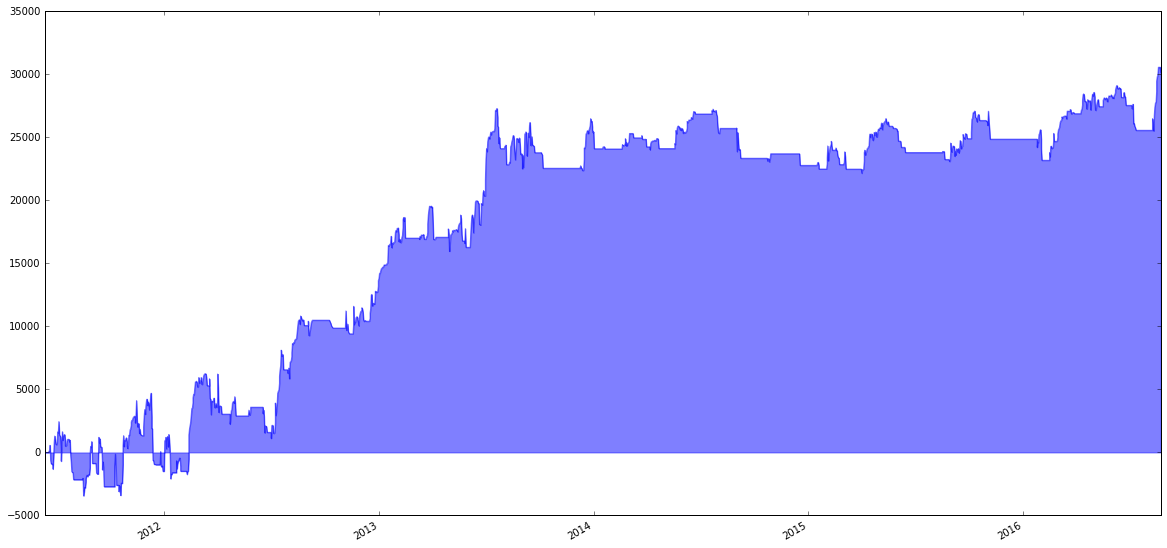

In [240]:
portfolio_stats(best_portfolio, 'Best')

Portfolio name --- Worst(reversed)


PriceChange Mod. Sharpe 0.0102603404656
Netprofit 4794.96646893
Max DD -9151.95542145
Recovery Factor 0.523928084013
Profit factor 1.09263903348
Winrate 5.7683433318


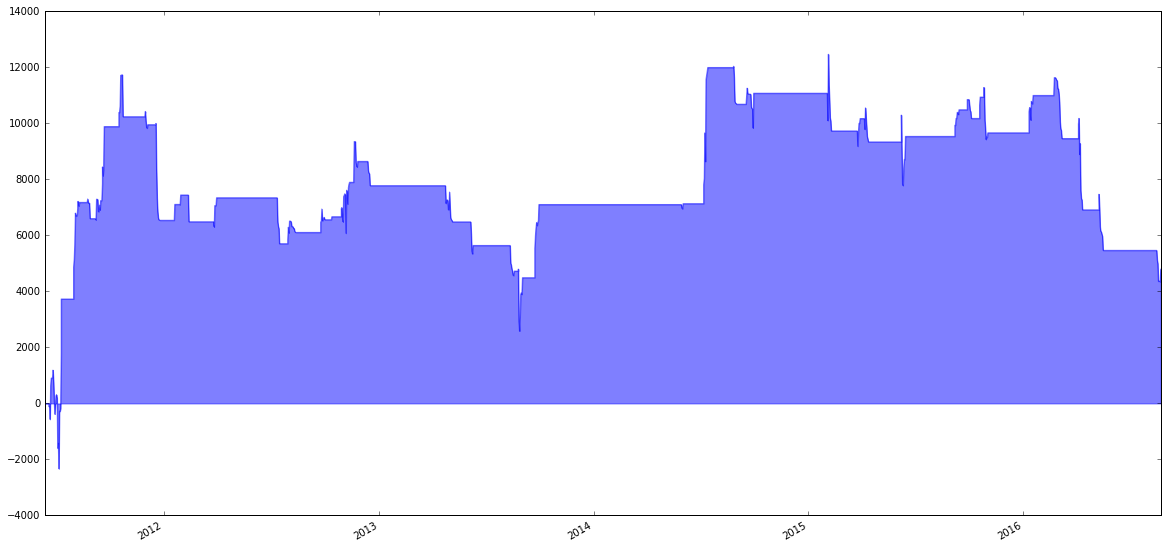

In [241]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

Portfolio name --- Summary(Best + Worst)


PriceChange Mod. Sharpe 0.0434235119136
Netprofit 34934.7822921
Max DD -10201.6617742
Recovery Factor 3.42442075276
Profit factor 1.2098848715
Winrate 28.564836179


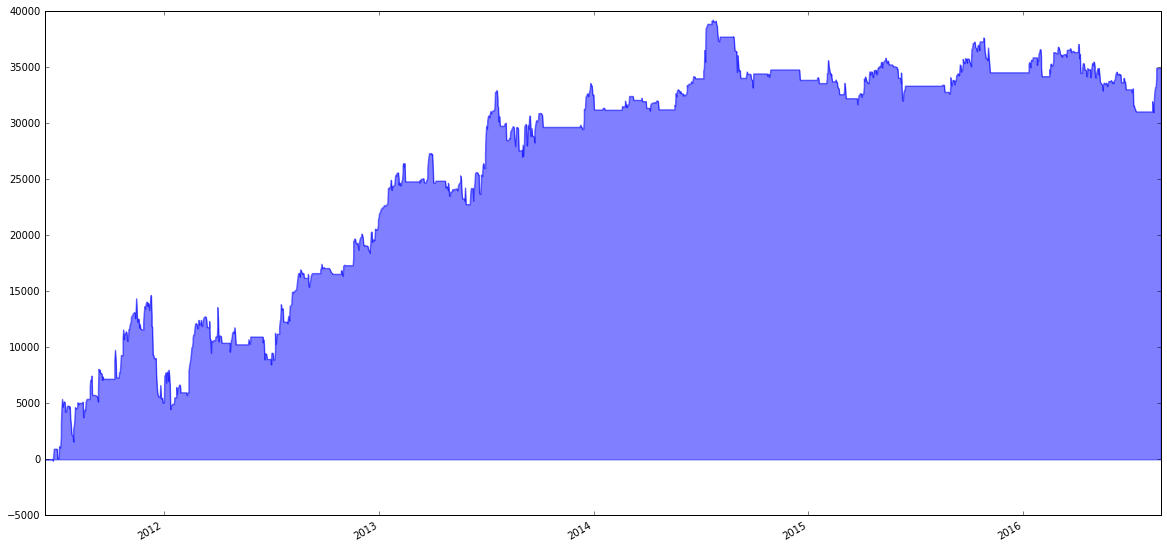

In [242]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

Portfolio name --- Benchmark(Trade all strategies)


PriceChange Mod. Sharpe 0.0161614618439
Netprofit 115474.823032
Max DD -128888.23876
Recovery Factor 0.895929870278
Profit factor 1.05725317402
Winrate 48.3617904938


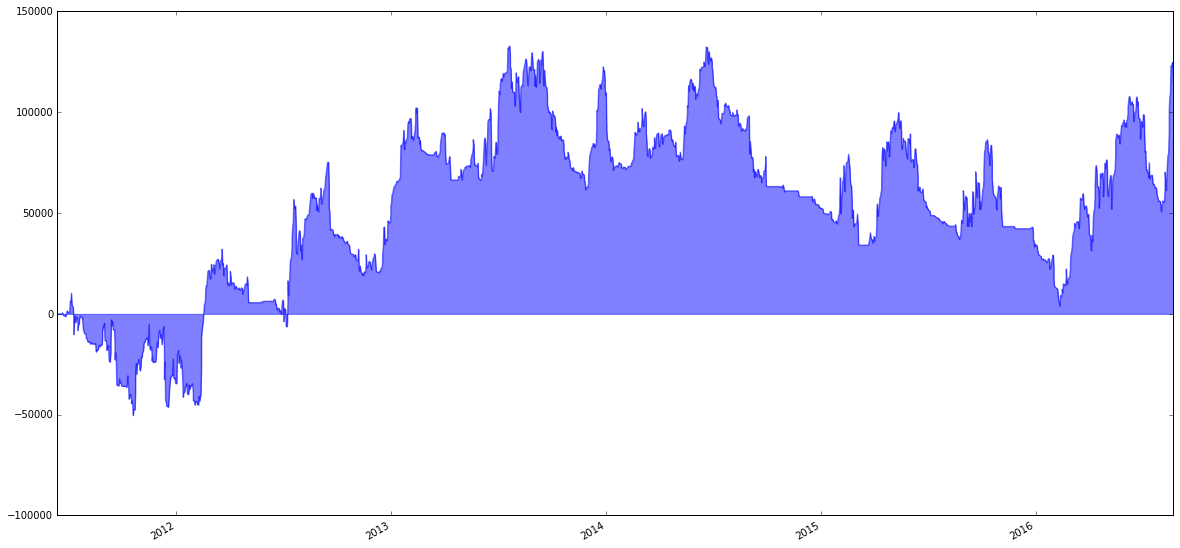

In [243]:
portfolio_stats(benchmark_portfolio, 'Benchmark(Trade all strategies)')

In [ ]:
portfolio_stats(swarm.picked_equity, 'Picked swarm with current approach')